In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io

from collections import OrderedDict

from descartes import PolygonPatch
import alphashape # Alpha Shape Toolbox

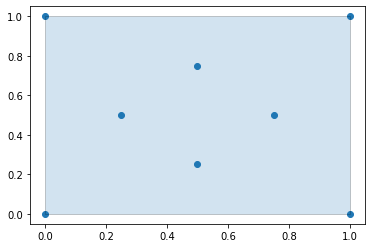

In [3]:
points_2d = [(0., 0.), (0., 1.), (1., 1.), (1., 0.),
          (0.5, 0.25), (0.5, 0.75), (0.25, 0.5), (0.75, 0.5)]

alpha_shape = alphashape.alphashape(points_2d, 0.)

fig, ax = plt.subplots()
ax.scatter(*zip(*points_2d))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.show()

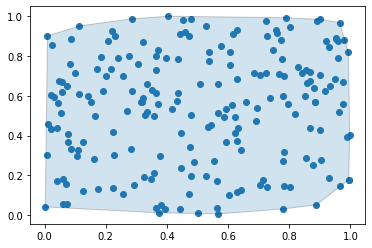

In [4]:
# randomly generate distribution of particles
np.random.seed(1234)
X = np.asarray([(np.random.uniform(), np.random.uniform()) for _ in range(200)])

fig, ax = plt.subplots()
ax.scatter(*zip(*X))

# identify boundary through ball-pivoting algorithm (BPA)
alpha_shape = alphashape.alphashape(X, 0.)
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.show()

In [5]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = [2, 20, 20, 20, 20, 20, 20, 2] 
        self.depth = len(self.layers) - 1

        self.activation = nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(self.layers[i], self.layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), nn.Linear(self.layers[-2], self.layers[-1])))

        layerDict = OrderedDict(layer_list)
        self.model = nn.Sequential(layerDict)

    def forward(self, x):
        out = self.model(x)
        return out

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nu = 0.01/np.pi

loss_history = []

class NS:
    def __init__(self, X, T, u):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)

        self.u = torch.tensor(u, dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x.shape[0], 1)).to(device)
        
        self.net = DNN().to(device)

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000, 
                                           history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
        
        self.mse = nn.MSELoss().to(device)

        self.ls = 0
        self.iter = 0

    def function(self, x, t):
        res = self.net(torch.hstack((x, t)))
        u, p = res[:, 0:1], res[:, 1:2]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]


        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), 
                                  create_graph=True)[0]

        f = u_t + u * u_x + p_x - nu * u_xx

        return u, p, f
    
    def closure(self):
        self.optimizer.zero_grad()

        u_pred, p_pred, f_pred = self.function(self.x, self.t)

        u_loss = self.mse(u_pred, self.u)
        f_loss = self.mse(f_pred, self.null)

        self.ls = u_loss + f_loss 

        loss_history.append(self.ls.detach().cpu().numpy())

        self.ls.backward()

        self.iter += 1
        if not self.iter % 1: 
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls
    

    def train(self):
        self.net.train()
        self.optimizer.step(self.closure)

In [7]:
data = scipy.io.loadmat("C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\dambreak_data.mat")

In [8]:
N_train = 5000

t_star = data['T']
X_star = data['X']
U_star = data['usol']

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star
u_test = U_star
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

# Rearrange Data
XX = np.tile(X_star, (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]


In [9]:
u_test.shape

(256, 100)

In [10]:
PINN = NS(x_train, t_train, u_train)
PINN.train()

Iteration: 1, Loss: 0.013328
Iteration: 2, Loss: 0.016037
Iteration: 3, Loss: 0.013080
Iteration: 4, Loss: 0.013059
Iteration: 5, Loss: 0.012881
Iteration: 6, Loss: 0.011803
Iteration: 7, Loss: 0.011729
Iteration: 8, Loss: 0.011521
Iteration: 9, Loss: 0.011486
Iteration: 10, Loss: 0.011455
Iteration: 11, Loss: 0.011288
Iteration: 12, Loss: 0.011129
Iteration: 13, Loss: 0.011015
Iteration: 14, Loss: 0.010972
Iteration: 15, Loss: 0.010961
Iteration: 16, Loss: 0.010956
Iteration: 17, Loss: 0.010952
Iteration: 18, Loss: 0.010935
Iteration: 19, Loss: 0.010898
Iteration: 20, Loss: 0.010867
Iteration: 21, Loss: 0.010823
Iteration: 22, Loss: 0.010797
Iteration: 23, Loss: 0.010779
Iteration: 24, Loss: 0.010763
Iteration: 25, Loss: 0.010757
Iteration: 26, Loss: 0.010748
Iteration: 27, Loss: 0.010731
Iteration: 28, Loss: 0.010667
Iteration: 29, Loss: 0.010892
Iteration: 30, Loss: 0.010460
Iteration: 31, Loss: 0.488199
Iteration: 32, Loss: 0.025966
Iteration: 33, Loss: 0.010486
Iteration: 34, Loss

In [11]:
PINN.net.eval()

DNN(
  (model): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [12]:
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

u_out, p_out, f_out = PINN.function(x_test, t_test)

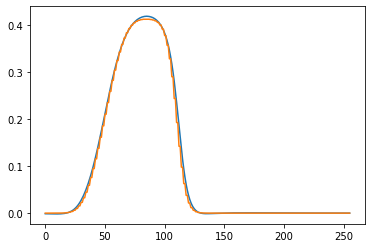

In [13]:
plt.plot(u_out.detach().cpu().numpy())
plt.plot(U_star[:, 97])

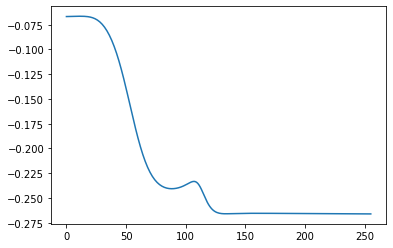

In [14]:
plt.plot(p_out.detach().cpu().numpy())

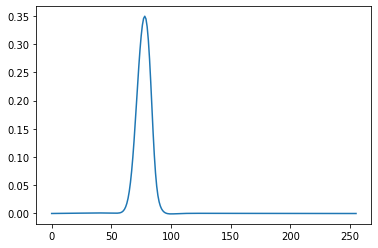

In [29]:
u_out, p_out, f_out = PINN.function(x_test, 0.20*t_test)
plt.plot(u_out.data.cpu().numpy())

MovieWriter ffmpeg unavailable; using Pillow instead.


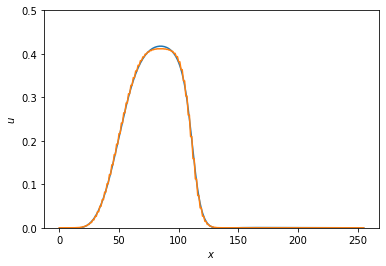

In [32]:
fig, ax = plt.subplots()

plt.plot(U_star[:, 0])
# plt.show()

def animate(i):
    ax.clear()
    ax.set_ylim(0, 0.5)
    u_out, p_out, f_out = PINN.function(x_test, 0.01*i*t_test)
    u_plot = u_out.data.cpu().numpy()
    cax = ax.plot(u_plot, label='prediction')
    cax2 = ax.plot(U_star[:, i], label='ground truth')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u$')
    ax.legend()
    
ani = animation.FuncAnimation(fig, animate, 100, interval=1, blit=False)
ani.save('results/dambreak.gif')
plt.show()
    


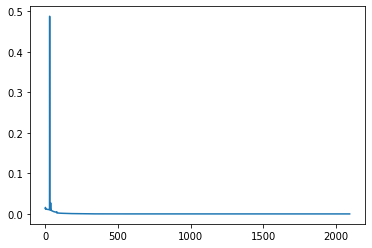

In [31]:
plt.plot(loss_history)